In [1]:
import time
import re
import pylab as pl
import numpy as np
import pylab as pl

from datetime import datetime, timedelta

import subprocess

import os
import pandas as pd

import concurrent.futures


from joblib import Parallel, delayed
import shutil


from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [2]:

os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')   


ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --keep-disks | --zone

For detailed information on this command and its flags, run:
  gcloud compute instances delete --help
ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --keep-disks | --zone

For detailed information on this command and its flags, run:
  gcloud compute instances delete --help
ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --k

512

In [3]:

def str2datetime(s):
    parts = s.split('.')
    dt = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S")
    return dt.replace(microsecond=int(parts[1]))


def remove_outliers(x, outlierConstant = 1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    removedList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
        else:
            removedList.append(y)
    return (resultList, removedList)
def getThroughput(experiment):

    result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


    result = result.decode("utf-8") 

    lines = result.split('\n')

    commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
#     commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

    Times = []
    lats = []

    for line in lines:
        m = commit_pat.match(line)
        if m:
            try:

                time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
                float((line.split(' ')[1]).split(':')[2])
                Times.append(time_item)        

                lats.append(float(m.group(2)))
            except:
                continue


    begin_time = None
    values = []
    interval = 1
    cnt = 0
    Times.sort()
    for timestamp in Times:
        if begin_time is None:
            begin_time = timestamp
            next_begin_time = timestamp +interval

        while timestamp >= next_begin_time:
            begin_time = next_begin_time
            next_begin_time += interval
            values.append(cnt)
            cnt = 0
        cnt += 1
    values.append(cnt)

#     lats, _ = remove_outliers(lats)
#     print(len(values))


    return np.arange(len(values))*interval,np.array(values)/interval, lats

In [4]:
# p = subprocess.Popen(['../../hotstuff-keygen', ' --num', '--n', str(4)],
#                      stdout=subprocess.PIPE, stderr=open(os.devnull, 'w'))

In [5]:
# print([[t[4:] for t in l.decode('ascii').split()] for l in p.stdout])
# # [[t for t in l.decode('ascii').split()] for l in p.stdout.read()]

In [6]:
# os.system('echo 3108 | sudo -S sh job_mini.sh '+ 'test')


In [7]:
# regions= ['us-west-1', 'ap-south-1']
# regions= ['ap-south-1', 'eu-central-1', 'us-west-2']
# regions= ['ap-south-1', 'eu-central-1']
regions= ['ap-south-1']


instance_type = 't2.small'

In [8]:
# df

In [9]:

# # Node config for remote view change and leader/non leader failures

# %%file node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
# 1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
# 2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
# 3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
# 4, 'ap-south-1', 0, 0, 'FKA.pem', -1, 4,
# 5, 'ap-south-1', 0, 0, 'FKA.pem', -1, 5,
# 6, 'ap-south-1', 0, 0, 'FKA.pem', -1, 6,
# 7, 'ap-south-1', 0, 0, 'FKA.pem', -1, 7,
# 8, 'ap-south-1', 0, 0, 'FKA.pem', -1, 8,
# 9, 'ap-south-1', 0, 0, 'FKA.pem', -1, 9,
# 10, 'ap-south-1', 0, 0, 'FKA.pem', -1, 10,
# 11, 'ap-south-1', 0, 0, 'FKA.pem', -1, 11,
# 12, 'ap-south-1', 0, 0, 'FKA.pem', -1, 12,
# 13, 'ap-south-1', 0, 0, 'FKA.pem', -1, 13,
# 14, 'ap-south-1', 0, 0, 'FKA.pem', -1, 14,
# 15, 'ap-south-1', 0, 0, 'FKA.pem', -1, 15,
# 16, 'ap-south-1', 0, 0, 'FKA.pem', -1, 16,
# 17, 'ap-south-1', 0, 0, 'FKA.pem', -1, 17,
# 18, 'ap-south-1', 0, 0, 'FKA.pem', -1, 18,
# 19, 'ap-south-1', 0, 0, 'FKA.pem', -1, 19,
# 20, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
# 21, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,



In [10]:
%%file node_info.csv
node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
0, 'asia-south1-c', 0, 0, 'FKA.pem', -1, 0,
1, 'asia-south1-c', 0, 0, 'FKA.pem', -1, 1,
2, 'asia-south1-c', 0, 0, 'FKA.pem', -1, 2,
3, 'asia-south1-c', 0, 0, 'FKA.pem', -1, 3,
4, 'asia-south1-c', 0, 0, 'FKA.pem', -1, 4,
5, 'asia-south1-c', 0, 0, 'FKA.pem', -1, 5,
6, 'asia-south1-c', 0, 0, 'FKA.pem', -1, 6,
7, 'asia-south1-c', 0, 0, 'FKA.pem', -1, 7,
8, 'asia-south1-c', 0, 1, 'FKA.pem', -1, 8,
9, 'asia-south1-c', 0, 1, 'FKA.pem', -1, 9,
10, 'asia-south1-c', 0, 1, 'FKA.pem', -1, 10,
11, 'asia-south1-c', 0, 1, 'FKA.pem', -1, 11,
12, 'asia-south1-c', 0, 1, 'FKA.pem', -1, 12,
13, 'asia-south1-c', 0, 1, 'FKA.pem', -1, 13,
14, 'asia-south1-c', 0, 1, 'FKA.pem', -1, 14,
15, 'asia-south1-c', 0, 1, 'FKA.pem', -1, 15,
16, 'asia-south1-c', 1, -1, 'FKA.pem', 0, -1,
17, 'asia-south1-c', 1, -1, 'FKA.pem', 1, -1,
18, 'asia-south1-c', 1, -1, 'FKA.pem', 2, -1,
19, 'asia-south1-c', 1, -1, 'FKA.pem', 3, -1,
20, 'europe-west3-c', 0, 2, 'FKE.pem', -1, 16,
21, 'europe-west3-c', 0, 2, 'FKE.pem', -1, 17,
22, 'europe-west3-c', 0, 2, 'FKE.pem', -1, 18,
23, 'europe-west3-c', 0, 2, 'FKE.pem', -1, 19,
24, 'europe-west3-c', 0, 2, 'FKE.pem', -1, 20,
25, 'europe-west3-c', 0, 2, 'FKE.pem', -1, 21,
26, 'europe-west3-c', 0, 2, 'FKE.pem', -1, 22,
27, 'europe-west3-c', 0, 2, 'FKE.pem', -1, 23,
28, 'europe-west3-c', 0, 3, 'FKE.pem', -1, 24,
29, 'europe-west3-c', 0, 3, 'FKE.pem', -1, 25,
30, 'europe-west3-c', 0, 3, 'FKE.pem', -1, 26,
31, 'europe-west3-c', 0, 3, 'FKE.pem', -1, 27,
32, 'europe-west3-c', 0, 3, 'FKE.pem', -1, 28,
33, 'europe-west3-c', 0, 3, 'FKE.pem', -1, 29,
34, 'europe-west3-c', 0, 3, 'FKE.pem', -1, 30,
35, 'europe-west3-c', 0, 3, 'FKE.pem', -1, 31,
36, 'europe-west3-c', 1, -1, 'FKE.pem', 4, -1,
37, 'europe-west3-c', 1, -1, 'FKE.pem', 5, -1,
38, 'europe-west3-c', 1, -1, 'FKE.pem', 6, -1,
39, 'europe-west3-c', 1, -1, 'FKE.pem', 7, -1,
40, 'us-west1-b', 0, 4, 'FKU2.pem', -1, 32,
41, 'us-west1-b', 0, 4, 'FKU2.pem', -1, 33,
42, 'us-west1-b', 0, 4, 'FKU2.pem', -1, 34,
43, 'us-west1-b', 0, 4, 'FKU2.pem', -1, 35,
44, 'us-west1-b', 0, 4, 'FKU2.pem', -1, 36,
45, 'us-west1-b', 0, 4, 'FKU2.pem', -1, 37,
46, 'us-west1-b', 0, 4, 'FKU2.pem', -1, 38,
47, 'us-west1-b', 0, 4, 'FKU2.pem', -1, 39,
48, 'us-west1-b', 0, 5, 'FKU2.pem', -1, 40,
49, 'us-west1-b', 0, 5, 'FKU2.pem', -1, 41,
50, 'us-west1-b', 0, 5, 'FKU2.pem', -1, 42,
51, 'us-west1-b', 0, 5, 'FKU2.pem', -1, 43,
52, 'us-west1-b', 0, 5, 'FKU2.pem', -1, 44,
53, 'us-west1-b', 0, 5, 'FKU2.pem', -1, 45,
54, 'us-west1-b', 0, 5, 'FKU2.pem', -1, 46,
55, 'us-west1-b', 0, 5, 'FKU2.pem', -1, 47,
56, 'us-west1-b', 1, -1, 'FKU2.pem', 8, -1,
57, 'us-west1-b', 1, -1, 'FKU2.pem', 9, -1,
58, 'us-west1-b', 1, -1, 'FKU2.pem', 10, -1,
59, 'us-west1-b', 1, -1, 'FKU2.pem', 11, -1,

In [11]:
# %%file node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'us-west1-b', 0, 0, 'FKA.pem', -1, 0,
# 1, 'us-west1-b', 0, 0, 'FKA.pem', -1, 1,
# 2, 'us-west1-b', 0, 0, 'FKA.pem', -1, 2,
# 3, 'us-west1-b', 0, 0, 'FKA.pem', -1, 3,
# 4, 'us-west1-b', 0, 1, 'FKA.pem', -1, 4,
# 5, 'us-west1-b', 0, 1, 'FKA.pem', -1, 5,
# 6, 'us-west1-b', 0, 1, 'FKA.pem', -1, 6,
# 7, 'us-west1-b', 0, 1, 'FKA.pem', -1, 7,
# 8, 'us-west1-b', 0, 2, 'FKA.pem', -1, 8,
# 9, 'us-west1-b', 0, 2, 'FKA.pem', -1, 9,
# 10, 'us-west1-b', 0, 2, 'FKA.pem', -1, 10,
# 11, 'us-west1-b', 0, 2, 'FKA.pem', -1, 11,
# 12, 'us-west1-b', 0, 3, 'FKA.pem', -1, 12,
# 13, 'us-west1-b', 0, 3, 'FKA.pem', -1, 13,
# 14, 'us-west1-b', 0, 3, 'FKA.pem', -1, 14,
# 15, 'us-west1-b', 0, 3, 'FKA.pem', -1, 15,
# 16, 'us-west1-b', 0, 4, 'FKA.pem', -1, 16,
# 17, 'us-west1-b', 0, 4, 'FKA.pem', -1, 17,
# 18, 'us-west1-b', 0, 4, 'FKA.pem', -1, 18,
# 19, 'us-west1-b', 0, 4, 'FKA.pem', -1, 19,
# 20, 'us-west1-b', 0, 5,'FKA.pem', -1, 20,
# 21, 'us-west1-b', 0, 5,'FKA.pem', -1, 21,
# 22, 'us-west1-b', 0, 5,'FKA.pem', -1, 22,
# 23, 'us-west1-b', 0, 5,'FKA.pem', -1, 23,
# 24, 'us-west1-b', 0, 6,'FKA.pem', -1, 24,
# 25, 'us-west1-b', 0, 6,'FKA.pem', -1, 25,
# 26, 'us-west1-b', 0, 6,'FKA.pem', -1, 26,
# 27, 'us-west1-b', 0, 6,'FKA.pem', -1, 27,
# 28, 'us-west1-b', 0, 7,'FKA.pem', -1, 28,
# 29, 'us-west1-b', 0, 7,'FKA.pem', -1, 29,
# 30, 'us-west1-b', 0, 7,'FKA.pem', -1, 30,
# 31, 'us-west1-b', 0, 7,'FKA.pem', -1, 31,
# 32, 'us-west1-b', 0, 8,'FKA.pem', -1, 32,
# 33, 'us-west1-b', 0, 8,'FKA.pem', -1, 33,
# 34, 'us-west1-b', 0, 8,'FKA.pem', -1, 34,
# 35, 'us-west1-b', 0, 8,'FKA.pem', -1, 35,
# 36, 'us-west1-b', 0, 9,'FKA.pem', -1, 36,
# 37, 'us-west1-b', 0, 9,'FKA.pem', -1, 37,
# 38, 'us-west1-b', 0, 9,'FKA.pem', -1, 38,
# 39, 'us-west1-b', 0, 9,'FKA.pem', -1, 39,
# 40, 'us-west1-b', 0, 10,'FKA.pem', -1, 40,
# 41, 'us-west1-b', 0, 10,'FKA.pem', -1, 41,
# 42, 'us-west1-b', 0, 10, 'FKA.pem', -1, 42,
# 43, 'us-west1-b', 0, 10, 'FKA.pem', -1, 43,
# 44, 'us-west1-b', 0, 11, 'FKA.pem', -1, 44,
# 45, 'us-west1-b', 0, 11, 'FKA.pem', -1, 45,
# 46, 'us-west1-b', 0, 11, 'FKA.pem', -1, 46,
# 47, 'us-west1-b', 0, 11, 'FKA.pem', -1, 47,
# 48, 'us-west1-b', 1, -1, 'FKA.pem', 0, -1,
# 49, 'us-west1-b', 1, -1, 'FKA.pem', 1, -1,
# 50, 'us-west1-b', 1, -1, 'FKA.pem', 2, -1,
# 51, 'us-west1-b', 1, -1, 'FKA.pem', 3, -1,
# 52, 'us-west1-b', 1, -1, 'FKA.pem', 4, -1,
# 53, 'us-west1-b', 1, -1, 'FKA.pem', 5, -1,
# 54, 'us-west1-b', 1, -1, 'FKA.pem', 6, -1,
# 55, 'us-west1-b', 1, -1, 'FKA.pem', 7, -1,
# 56, 'us-west1-b', 1, -1, 'FKA.pem', 8, -1,
# 57, 'us-west1-b', 1, -1, 'FKA.pem', 9, -1,
# 58, 'us-west1-b', 1, -1, 'FKA.pem', 10, -1,
# 59, 'us-west1-b', 1, -1, 'FKA.pem', 11, -1,


Overwriting node_info.csv


In [12]:
df =pd.read_csv('node_info.csv')

node_info_dict = df.to_dict()

node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'us-west1-b'",
  1: " 'us-west1-b'",
  2: " 'us-west1-b'",
  3: " 'us-west1-b'",
  4: " 'us-west1-b'",
  5: " 'us-west1-b'",
  6: " 'us-west1-b'",
  7: " 'us-west1-b'",
  8: " 'us-west1-b'",
  9: " 'us-west1-b'",
  10: " 'us-west1-b'",
  11: " 'us-west1-b'",
  12: " 'us-west1-b'",
  13: " 'us-west1-b'",
  14: " 'us-west1-b'",
  15: " 'us-west1-b'",
  16: " 'us-west1-b'",
  17: " 'us-west1

In [13]:
lines  = []



for node_id in node_info_dict['node_id'].keys():
#     print(node_id, node_info_dict['node_id'][node_id], node_info_dict['region'][node_id])

    lim = node_info_dict['node_id'][node_id]
    reg = node_info_dict['region'][node_id].strip().replace('\'', '')

#     print(reg)

    cmd = 'gcloud compute instances create resdb-'+f"{lim:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
#     cmd = 'gcloud compute instances create resdb-'+f"{lim:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-small --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'

    lines.append(cmd)


lines

['gcloud compute instances create resdb-00 --project=ucr-ursa-major-lesani-lab --zone=us-west1-b --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels

In [14]:

def run_command(command):
    subprocess.call(command, shell=True)

commands = lines

# Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
    # Submit each command to the executor for parallel execution
    futures = [executor.submit(run_command, command) for command in commands]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)


instance_type = 'e2-small'


redirect = '>'

os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
          redirect+' all_internal_ips')



os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
      redirect+' all_external_ips')



Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-15].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-23].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-10].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-15  us-west1-b  e2-highmem-2               10.138.0.13  35.233.152.0  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-23  us-west1-b  e2-highmem-2               10.138.0.3   34.82.222.201  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-10  us-west1-b  e2-highmem-2               10.138.0.12  34.82.176.207  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-19].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-00].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-19  us-west1-b  e2-highmem-2               10.138.0.35  35.233.180.231  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-00  us-west1-b  e2-highmem-2               10.138.0.18  35.230.127.93  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-17].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-05].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-02].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-24].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-06].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-17  us-west1-b  e2-highmem-2               10.138.0.26  34.83.155.249  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-08].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-21].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-12].
Created [https://www.googleapis.com/compute/v1

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-02  us-west1-b  e2-highmem-2               10.138.0.57  35.247.15.80  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-06  us-west1-b  e2-highmem-2               10.138.0.6   34.168.32.199  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-24  us-west1-b  e2-highmem-2               10.138.0.54  35.203.159.255  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-08  us-west1-b  e2-highmem-2               10.138.0.43  34.168.196.63  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-05  us-west1-b  e2-highmem-2               10.138.0.39  34.83.68.185  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-59].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-21  us-west1-b  e2-highmem-2               10.138.0.88  34.168.254.140  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-27  us-west1-b  e2-highmem-2               10.138.0.15  34.82.52.251  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-12  us-west1-b  e2-highmem-2               10.138.0.11  34.145.125.59  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-07].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-03].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-52].
Created [https://www.googleapis.com/compute/v1

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-14  us-west1-b  e2-highmem-2               10.138.0.4   34.105.125.175  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-58  us-west1-b  e2-highmem-2               10.138.0.93  35.227.142.198  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-59  us-west1-b  e2-highmem-2               10.138.0.69  34.127.76.143  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-40].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-56].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-53].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/glob

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-16  us-west1-b  e2-highmem-2               10.138.0.76  35.247.127.110  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-32  us-west1-b  e2-highmem-2               10.138.0.87  34.168.41.115  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-13].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-03  us-west1-b  e2-highmem-2               10.138.0.17  35.185.201.96  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-07  us-west1-b  e2-highmem-2               10.138.0.20  34.168.9.116  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-53  us-west1-b  e2-highmem-2               10.138.0.53  34.83.228.94  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-20].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-37].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-33  us-west1-b  e2-highmem-2               10.138.0.56  34.168.198.77  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-18  us-west1-b  e2-highmem-2               10.138.0.14  34.105.45.68  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-40  us-west1-b  e2-highmem-2               10.138.0.120  34.105.10.55  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-52  us-west1-b  e2-highmem-2               10.138.0.110  34.105.108.128  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-56  us-west1-b  e2-highmem-2               10.138.0.116  35.233.191.70  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-25].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-09].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-49].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-13  us-west1-b  e2-highmem-2               10.138.0.83  34.82.72.219  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-37  us-west1-b  e2-highmem-2               10.138.15.210  35.230.30.117  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-20  us-west1-b  e2-highmem-2               10.138.0.21  34.83.80.0   RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-28].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-47].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-09  us-west1-b  e2-highmem-2               10.138.0.23  34.83.15.131  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-25  us-west1-b  e2-highmem-2               10.138.0.8   35.185.242.46  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-01  us-west1-b  e2-highmem-2               10.138.0.66  34.168.232.253  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-49  us-west1-b  e2-highmem-2               10.138.15.207  34.82.68.210  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-47  us-west1-b  e2-highmem-2               10.138.0.24  35.203.176.43  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-22].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-04].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-11].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-28  us-west1-b  e2-highmem-2               10.138.0.98  35.247.93.202  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-22  us-west1-b  e2-highmem-2               10.138.0.44  104.198.1.135  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-04  us-west1-b  e2-highmem-2               10.138.15.220  34.168.167.247  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-11  us-west1-b  e2-highmem-2               10.138.0.28  35.247.39.122  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-54].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-38].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-26].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-54  us-west1-b  e2-highmem-2               10.138.0.42  34.127.101.122  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-38  us-west1-b  e2-highmem-2               10.138.15.223  34.168.222.210  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-50].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-51].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-41].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-26  us-west1-b  e2-highmem-2               10.138.0.122  34.168.95.68  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-43].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-35].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-50  us-west1-b  e2-highmem-2               10.138.0.74  35.185.251.5  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-41  us-west1-b  e2-highmem-2               10.138.15.196  34.83.206.244  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-51  us-west1-b  e2-highmem-2               10.138.0.78  35.197.29.86  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-31].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-55].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-44].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-43  us-west1-b  e2-highmem-2               10.138.0.90  34.127.44.252  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-35  us-west1-b  e2-highmem-2               10.138.15.206  34.83.121.201  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-31  us-west1-b  e2-highmem-2               10.138.0.126  35.233.147.50  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-55  us-west1-b  e2-highmem-2               10.138.15.197  104.198.107.5  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-46].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-45].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-44  us-west1-b  e2-highmem-2               10.138.0.75  35.197.3.235  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-46  us-west1-b  e2-highmem-2               10.138.15.205  34.82.16.211  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-36].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP  STATUS
resdb-45  us-west1-b  e2-highmem-2               10.138.15.194  35.230.2.7   RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-42  us-west1-b  e2-highmem-2               10.138.0.94  35.230.91.15  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-36  us-west1-b  e2-highmem-2               10.138.0.60  34.83.176.98  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-30].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-57].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-29].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-48].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-30  us-west1-b  e2-highmem-2               10.138.15.214  34.168.213.6  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-57  us-west1-b  e2-highmem-2               10.138.15.216  104.198.111.4  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-29  us-west1-b  e2-highmem-2               10.138.15.219  35.233.178.56  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-39].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-48  us-west1-b  e2-highmem-2               10.138.0.51  34.168.147.20  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-39  us-west1-b  e2-highmem-2               10.138.0.124  104.199.126.27  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-34  us-west1-b  e2-highmem-2               10.138.15.202  34.83.148.127  RUNNING


0

In [15]:
!cat all_internal_ips
! echo " " 
# !cat all_external_ips

10.138.0.18
10.138.0.66
10.138.0.57
10.138.0.17
10.138.15.220
10.138.0.39
10.138.0.6
10.138.0.20
10.138.0.43
10.138.0.23
10.138.0.12
10.138.0.28
10.138.0.11
10.138.0.83
10.138.0.4
10.138.0.13
10.138.0.76
10.138.0.26
10.138.0.14
10.138.0.35
10.138.0.21
10.138.0.88
10.138.0.44
10.138.0.3
10.138.0.54
10.138.0.8
10.138.0.122
10.138.0.15
10.138.0.98
10.138.15.219
10.138.15.214
10.138.0.126
10.138.0.87
10.138.0.56
10.138.15.202
10.138.15.206
10.138.0.60
10.138.15.210
10.138.15.223
10.138.0.124
10.138.0.120
10.138.15.196
10.138.0.94
10.138.0.90
10.138.0.75
10.138.15.194
10.138.15.205
10.138.0.24
10.138.0.51
10.138.15.207
10.138.0.74
10.138.0.78
10.138.0.110
10.138.0.53
10.138.0.42
10.138.15.197
10.138.0.116
10.138.15.216
10.138.0.93
10.138.0.69
 


In [16]:
f = open('all_external_ips', "r")
data1 = [line.strip() for line in f.readlines()]

data1 = [x for x in data1 if x!='None']

In [17]:
f = open('all_internal_ips', "r")
data2 = [line.strip() for line in f.readlines()]

data2 = [x for x in data2 if x!='None']

In [18]:
data2, len(data2)

(['10.138.0.18',
  '10.138.0.66',
  '10.138.0.57',
  '10.138.0.17',
  '10.138.15.220',
  '10.138.0.39',
  '10.138.0.6',
  '10.138.0.20',
  '10.138.0.43',
  '10.138.0.23',
  '10.138.0.12',
  '10.138.0.28',
  '10.138.0.11',
  '10.138.0.83',
  '10.138.0.4',
  '10.138.0.13',
  '10.138.0.76',
  '10.138.0.26',
  '10.138.0.14',
  '10.138.0.35',
  '10.138.0.21',
  '10.138.0.88',
  '10.138.0.44',
  '10.138.0.3',
  '10.138.0.54',
  '10.138.0.8',
  '10.138.0.122',
  '10.138.0.15',
  '10.138.0.98',
  '10.138.15.219',
  '10.138.15.214',
  '10.138.0.126',
  '10.138.0.87',
  '10.138.0.56',
  '10.138.15.202',
  '10.138.15.206',
  '10.138.0.60',
  '10.138.15.210',
  '10.138.15.223',
  '10.138.0.124',
  '10.138.0.120',
  '10.138.15.196',
  '10.138.0.94',
  '10.138.0.90',
  '10.138.0.75',
  '10.138.15.194',
  '10.138.15.205',
  '10.138.0.24',
  '10.138.0.51',
  '10.138.15.207',
  '10.138.0.74',
  '10.138.0.78',
  '10.138.0.110',
  '10.138.0.53',
  '10.138.0.42',
  '10.138.15.197',
  '10.138.0.116',
  '10

In [19]:
data = []

In [20]:
# for i in range(len(data1)):
#     if data1[i]!='None':
# #         data.append(data1[i] + '    ' + data2[i])
#         data.append('127.0.0.1'+ '    ' + '127.0.0.1')
    

skip_instances = 0
    
for i in range(skip_instances, len(data1)):
    if data1[i]!='None':
        data.append(data1[i] + '    ' + data2[i])
#         data.append('127.0.0.1'+ '    ' + '127.0.0.1')

In [21]:
data, len(data)

(['10.138.0.18    10.138.0.18',
  '10.138.0.66    10.138.0.66',
  '10.138.0.57    10.138.0.57',
  '10.138.0.17    10.138.0.17',
  '10.138.15.220    10.138.15.220',
  '10.138.0.39    10.138.0.39',
  '10.138.0.6    10.138.0.6',
  '10.138.0.20    10.138.0.20',
  '10.138.0.43    10.138.0.43',
  '10.138.0.23    10.138.0.23',
  '10.138.0.12    10.138.0.12',
  '10.138.0.28    10.138.0.28',
  '10.138.0.11    10.138.0.11',
  '10.138.0.83    10.138.0.83',
  '10.138.0.4    10.138.0.4',
  '10.138.0.13    10.138.0.13',
  '10.138.0.76    10.138.0.76',
  '10.138.0.26    10.138.0.26',
  '10.138.0.14    10.138.0.14',
  '10.138.0.35    10.138.0.35',
  '10.138.0.21    10.138.0.21',
  '10.138.0.88    10.138.0.88',
  '10.138.0.44    10.138.0.44',
  '10.138.0.3    10.138.0.3',
  '10.138.0.54    10.138.0.54',
  '10.138.0.8    10.138.0.8',
  '10.138.0.122    10.138.0.122',
  '10.138.0.15    10.138.0.15',
  '10.138.0.98    10.138.0.98',
  '10.138.15.219    10.138.15.219',
  '10.138.15.214    10.138.15.214',
  

In [22]:
for index, item in enumerate(data1):
    if 'publicIP' not in node_info_dict.keys():
        node_info_dict['publicIP'] = {}

        
    node_info_dict['publicIP'][index] = item 
    
    
for index, item in enumerate(data2):
    if 'privateIP' not in node_info_dict.keys():
        node_info_dict['privateIP'] = {}
        
    node_info_dict['privateIP'][index] = item 
    
    
    
for index, item in enumerate(data):
    if 'publicAndprivateIP' not in node_info_dict.keys():
        node_info_dict['publicAndprivateIP'] = {}
        
    node_info_dict['publicAndprivateIP'][index] = item 

In [23]:
node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'us-west1-b'",
  1: " 'us-west1-b'",
  2: " 'us-west1-b'",
  3: " 'us-west1-b'",
  4: " 'us-west1-b'",
  5: " 'us-west1-b'",
  6: " 'us-west1-b'",
  7: " 'us-west1-b'",
  8: " 'us-west1-b'",
  9: " 'us-west1-b'",
  10: " 'us-west1-b'",
  11: " 'us-west1-b'",
  12: " 'us-west1-b'",
  13: " 'us-west1-b'",
  14: " 'us-west1-b'",
  15: " 'us-west1-b'",
  16: " 'us-west1-b'",
  17: " 'us-west1

In [24]:
for item in node_info_dict['publicAndprivateIP']:
    print(node_info_dict['publicAndprivateIP'][item])

10.138.0.18    10.138.0.18
10.138.0.66    10.138.0.66
10.138.0.57    10.138.0.57
10.138.0.17    10.138.0.17
10.138.15.220    10.138.15.220
10.138.0.39    10.138.0.39
10.138.0.6    10.138.0.6
10.138.0.20    10.138.0.20
10.138.0.43    10.138.0.43
10.138.0.23    10.138.0.23
10.138.0.12    10.138.0.12
10.138.0.28    10.138.0.28
10.138.0.11    10.138.0.11
10.138.0.83    10.138.0.83
10.138.0.4    10.138.0.4
10.138.0.13    10.138.0.13
10.138.0.76    10.138.0.76
10.138.0.26    10.138.0.26
10.138.0.14    10.138.0.14
10.138.0.35    10.138.0.35
10.138.0.21    10.138.0.21
10.138.0.88    10.138.0.88
10.138.0.44    10.138.0.44
10.138.0.3    10.138.0.3
10.138.0.54    10.138.0.54
10.138.0.8    10.138.0.8
10.138.0.122    10.138.0.122
10.138.0.15    10.138.0.15
10.138.0.98    10.138.0.98
10.138.15.219    10.138.15.219
10.138.15.214    10.138.15.214
10.138.0.126    10.138.0.126
10.138.0.87    10.138.0.87
10.138.0.56    10.138.0.56
10.138.15.202    10.138.15.202
10.138.15.206    10.138.15.206
10.138.0.60 

In [25]:
with open('replicas.txt', 'w') as f:
    
    for item in node_info_dict['publicAndprivateIP']:
        
        if (node_info_dict['ServerOrClientregion'][item] ==0):
            f.write("%s\n" % node_info_dict['publicAndprivateIP'][item])
    

In [26]:
node_info_dict['ServerOrClientregion']

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1}

In [27]:
! cat replicas.txt

10.138.0.18    10.138.0.18
10.138.0.66    10.138.0.66
10.138.0.57    10.138.0.57
10.138.0.17    10.138.0.17
10.138.15.220    10.138.15.220
10.138.0.39    10.138.0.39
10.138.0.6    10.138.0.6
10.138.0.20    10.138.0.20
10.138.0.43    10.138.0.43
10.138.0.23    10.138.0.23
10.138.0.12    10.138.0.12
10.138.0.28    10.138.0.28
10.138.0.11    10.138.0.11
10.138.0.83    10.138.0.83
10.138.0.4    10.138.0.4
10.138.0.13    10.138.0.13
10.138.0.76    10.138.0.76
10.138.0.26    10.138.0.26
10.138.0.14    10.138.0.14
10.138.0.35    10.138.0.35
10.138.0.21    10.138.0.21
10.138.0.88    10.138.0.88
10.138.0.44    10.138.0.44
10.138.0.3    10.138.0.3
10.138.0.54    10.138.0.54
10.138.0.8    10.138.0.8
10.138.0.122    10.138.0.122
10.138.0.15    10.138.0.15
10.138.0.98    10.138.0.98
10.138.15.219    10.138.15.219
10.138.15.214    10.138.15.214
10.138.0.126    10.138.0.126
10.138.0.87    10.138.0.87
10.138.0.56    10.138.0.56
10.138.15.202    10.138.15.202
10.138.15.206    10.138.15.206
10.138.0.60 

In [28]:
with open('clients.txt', 'w') as f:
    
    for item in node_info_dict['publicIP']:
        
        if (node_info_dict['ServerOrClientregion'][item] ==1):
            f.write("%s\n" % node_info_dict['publicIP'][item])

In [29]:
os.system('cat clients.txt')

10.138.0.51
10.138.15.207
10.138.0.74
10.138.0.78
10.138.0.110
10.138.0.53
10.138.0.42
10.138.15.197
10.138.0.116
10.138.15.216
10.138.0.93
10.138.0.69


0

In [30]:
node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'us-west1-b'",
  1: " 'us-west1-b'",
  2: " 'us-west1-b'",
  3: " 'us-west1-b'",
  4: " 'us-west1-b'",
  5: " 'us-west1-b'",
  6: " 'us-west1-b'",
  7: " 'us-west1-b'",
  8: " 'us-west1-b'",
  9: " 'us-west1-b'",
  10: " 'us-west1-b'",
  11: " 'us-west1-b'",
  12: " 'us-west1-b'",
  13: " 'us-west1-b'",
  14: " 'us-west1-b'",
  15: " 'us-west1-b'",
  16: " 'us-west1-b'",
  17: " 'us-west1

In [31]:
# def run_server_node_remote(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None' and( ip in nodeIps):
        
        
#         current = (ip.split('.'))
#         command = './examples/hotstuff-app --conf hotstuff.gen-sec'+str(nodeIps.index(ip))+'.conf '
        
#         print(i,command)
        
        
        
# for i in range(len(lines)):
#     print(i)
#     run_server_node_remote(i)
    
    

        
# def run_client_node_remote(i):
#     ip = lines[i]
#     if ip!='None' and( ip in clientIps):
        
#         current = (ip.split('.'))
#         command = './examples/hotstuff-client --idx 0 --iter -1 --max-async 5 >../nohup.out 2>&1 &"'
        
#         print(command)

# for i in range(len(lines)):
#     print(i)
#     run_client_node_remote(i)


In [32]:
# # # os.system('echo 3108 | sudo -S ls')/FinalKeys.pem

# # experiment = 'exp_f1'

# # os.system('echo 3108 | sudo -S sh job_mini1.sh '+experiment)

# # os.system('./run_cli.sh new '+experiment+'_cli;')
# # os.system('sleep 30;')
# # kill_nodes(3)

# # # run_server_node(3)

# # os.system('sleep 30;')

# # os.system('./run_cli.sh stop '+experiment+'_cli;')
# # os.system('./run.sh stop '+experiment+';')
# # os.system('./run_cli.sh fetch '+experiment+'_cli;')
# # os.system('cat '+experiment+'_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')



# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None':

#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd /home/ubuntu/testbed/'+experiment+'/0/conf/; sudo nohup ../../../../libhotstuff/examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'+experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

#         print(command)
#         os.system(command)
        
        
# def run_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None' and ip in lines[:nnodes]:

#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf > ../temp/nohup_'+str(i)+'.out 2>&1 &'

#         print(command)
#         os.system(command)
        
        
# def run_client(i):
#     ip = lines[i]
#     client_no = i - nnodes
#     if ip!='None' and( ip in lines[nnodes:]):
        
#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'.out 2>&1 &'
        
#         print(command)
#         os.system(command)
        
        
        
# def run_client2(i):
#     ip = lines[i]
#     client_no = i - nnodes
#     if ip!='None' and( ip in lines[nnodes:]):
        
#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'_2.out 2>&1 &'
        
#         print(command)
#         os.system(command)
        
        
        
# # def run_join_node(i):
# #     ip = lines[i]
# #     if ip!='None':
        
# #         current = (ip.split('.'))
# #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'
# #         +experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
# #         print(command)
# #         os.system(command)
        

        

# # def kill_nodes(i):
# #     ip = lines[i]
    
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'
        
# #         output = subprocess.getoutput(command)
# #         print(output)

        



# # # run_server_node(3)

# # # current



# # os.system('cat exp_4c5n_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')

In [33]:

def setup_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo apt -y update;sudo apt -y install build-essential; sudo apt -y install autoconf libtool libssl-dev libuv1-dev cmake pkg-config cmake-data make; sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'

        print(command)

        output = os.system(command)
        print(output)


def setup_remote2(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))



        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; git pull;"'

        print(command)

        output = os.system(command)
        print(output)


def git_pull_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo git pull;"'


        output = subprocess.getoutput(command)
        print(output)


        
# def run_join_node_remote(i):
#     ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip == nodeIps[-1]):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
#         print(command)
#         os.system(command)
        
        
        
# def run_join_node1_remote(i):
#     ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip == nodeIps[-1]):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
#         print(command)
#         os.system(command)
        
# def run_join_node2_remote(i):
#     ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip == nodeIps[-2]):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
#         print(command)
#         os.system(command)
        
# def run_join_node3_remote(i):
#     ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip == nodeIps[-3]):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
#         print(command)
#         os.system(command)

        


def kill_nodes_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None':
        current = (ip.split('.'))

        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


        output = subprocess.getoutput(command)
        print(output)



def clean_nodes_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None':
        current = (ip.split('.'))

        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm -f nohup.out;"'


        print(command)
        os.system(command)




In [34]:
experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('echo 3108 | sudo -S sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

Name of TestRun: test
-- Found OpenSSL: /usr/lib/x86_64-linux-gnu/libcrypto.so (found suitable version "3.0.2", minimum required is "1.1.0")  
-- Found OpenSSL: /usr/lib/x86_64-linux-gnu/libcrypto.so (found version "3.0.2")  
-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /home/tejas/work/hotstuffO


[sudo] password for tejas: CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.




[ 21%] Built target libsecp256k1
Consolidate compiler generated dependencies of target hotstuff
Consolidate compiler generated dependencies of target salticidae
[ 37%] Built target hotstuff
[ 62%] Built target salticidae
[ 67%] Built target salticidae_shared
[ 67%] Built target salticidae_static
[ 70%] Built target hotstuff_shared
[ 72%] Built target hotstuff_static
Consolidate compiler generated dependencies of target hotstuff-tls-keygen
Consolidate compiler generated dependencies of target hotstuff-keygen
Consolidate compiler generated dependencies of target test_secp256k1
Consolidate compiler generated dependencies of target hotstuff-app
[ 81%] Built target hotstuff-tls-keygen
[ 83%] Built target hotstuff-keygen
[ 89%] Built target test_secp256k1
[ 94%] Built target hotstuff-app
Consolidate compiler generated dependencies of target hotstuff-client
[100%] Built target hotstuff-client
48 ../../hotstuff-keygen [['02dda1925887c090742e25c17c717a4075a9a509384bdd00233e611abcc33efa7a', 'a7e

0

In [35]:
import os
os.system('cd ../../; git add .; git commit -m "Testing"; git push -f')

[main 1d7f935] Testing
 106 files changed, 13470 insertions(+), 1202 deletions(-)
 rewrite hotstuff.gen-sec0.conf (91%)
 rewrite hotstuff.gen-sec1.conf (91%)
 rewrite hotstuff.gen-sec10.conf (91%)
 rewrite hotstuff.gen-sec11.conf (91%)
 rewrite hotstuff.gen-sec12.conf (90%)
 rewrite hotstuff.gen-sec13.conf (91%)
 rewrite hotstuff.gen-sec14.conf (91%)
 rewrite hotstuff.gen-sec15.conf (91%)
 rewrite hotstuff.gen-sec16.conf (91%)
 rewrite hotstuff.gen-sec17.conf (91%)
 rewrite hotstuff.gen-sec18.conf (91%)
 rewrite hotstuff.gen-sec19.conf (91%)
 rewrite hotstuff.gen-sec2.conf (91%)
 rewrite hotstuff.gen-sec20.conf (91%)
 rewrite hotstuff.gen-sec21.conf (91%)
 rewrite hotstuff.gen-sec22.conf (91%)
 rewrite hotstuff.gen-sec23.conf (91%)
 rewrite hotstuff.gen-sec24.conf (91%)
 rewrite hotstuff.gen-sec25.conf (91%)
 rewrite hotstuff.gen-sec26.conf (90%)
 rewrite hotstuff.gen-sec27.conf (91%)
 rewrite hotstuff.gen-sec28.conf (90%)
 rewrite hotstuff.gen-sec29.conf (91%)
 rewrite hotstuff.gen-se

To github.com:tmane002/hotstuffO.git
   40d49d0..1d7f935  main -> main


0

In [36]:

# # def setup_remote3(i):

# #     ip = node_info_dict['publicIP'][i] 
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
# #                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'
# #         print(command)
        
# #         output = os.system(command)
# #         print(output)


# results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
#                                                                        for i in [9])#node_info_dict['node_id'])


# print(results)  

In [37]:
time.sleep(60)

In [42]:
    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  


    
# for i in node_info_dict['publicIP']:
#     print(i)
#     setup_remote2(i)

Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]


Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2579 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backpor

Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]


Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2579 kB]
Get:15 http://us-west1.gce.archive

Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiver

Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
Hit:1 http://us-west1.gce.ar

Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 Packages [970 kB]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]


Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2579 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:13 http://us-west1.gce.archi

Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [360 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 h

Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [360 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:31 http

Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [195 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [406 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [

Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [195 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [406 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [195 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 


Reading state information...

Reading state information...
82 packages can be upgraded. Run 'apt list --upgradable' to see them.

Building dependency tree...Reading package lists...
Building dependency tree...

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Suggested packages:
 

Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
The following packa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-up

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 29.7 MB in 6s (5333 kB/s)
Reading package lists...Fetched 29.7 MB in 5s (5481 kB/s)
Reading package lists...Fetched 48.2 MB in 1s (61.5 MB/s)
Selecting previously unselected package binutils-common:amd64.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Fetched 29.7 MB in 6s (5301 kB/s)
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpa

Fetched 29.7 MB in 6s (5402 kB/s)
Reading package lists...Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Fetched 29.7 MB in 6s (5329 kB/s)
Reading package lists...
Reading state information...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking

82 packages can be upgraded. Run 'apt list --upgradable' to see them.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Reading package lists...Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Fetched 29.7 MB in 6s (5307 kB/s)
Reading package lists...Fetched 29.7 MB in 6s (5390 kB/s)
Reading package lists...
Building dependency tree...Reading package lists...Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...

Buil

Building dependency tree...
Reading state information...
82 packages can be upgraded. Run 'apt list --upgradable' to see them.

Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  li


The following packages will be upgraded:
  libc6
Fetched 29.7 MB in 6s (5153 kB/s)
Reading package lists...
Reading state information...
1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
Selecting previously unselected package binutils.
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
82 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-upda

Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Reading package lists...
Building dependency tree...Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




82 packages can be upgraded. Run 'apt list --upgradable' to see them.
Selecting previously unselected package cpp-9.
Reading package lists...1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Fetched 48.2 MB in 1s (51.3 MB/s)

Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Selecting previously unselected package cpp.
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9

Building dependency tree...The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
Need to get 8837 kB/48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]

The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 

Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Reading package lists...Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:40 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd









debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Building dependency tree...Reading package lists...Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 









Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Building dependency tree...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
(Reading database ... 80%
Reading state information...
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Reading package lists...The following 

(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]

(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Selecting previously unselected package binutils-common:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http:



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmp

Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ub

Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
  gdb gcc-doc gcc-9-multilib glibc-doc bzr libstdc++-9-doc make-doc
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libcc1-0:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20

Selecting previously unselected package libc6-dev:amd64.
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:40 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
debconf: unable to ini

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libis

Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package binutils-common:amd64.
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://us-west1.gce.archive

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-

Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package binutils.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http:/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Fetched 48.2 MB in 2s (26.2 MB/s)
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package binutils-common:amd64.
Fetched 48.2 MB in 2s (26.3 MB/s)
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Selecting previously unselected package binutils-x86-64-linux-gnu.
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Fetched 48.2 MB in 2s (24.7 MB/s)
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Fetched 48.2 MB in 2s (24.7 MB/s)
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libcc1-0:amd64.
62221 files and directories currently installed.)
Selecting previously 

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package g++.
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../02-libctf-nobfd0_2.3

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Selecting previously unselected package libfakeroot:amd64.
Unpacking libisl22:amd64 (0.22.1-1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpack

Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libitm1:amd64.
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Get:30 

Selecting previously unselected package libbinutils:amd64.
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package libquadmath0:amd64.
Unpacking libmpc3:amd64 (1.1.0-1) ...
Prepari

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package linux-li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package binutils.
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package gcc-9.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Selecting previously unselected package binutils-x86-64-linux-gnu.
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8

Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected pack

Selecting previously unselected package libisl22:amd64.
Unpacking libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package make.
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Selecting previously unselected package libisl22:amd64.
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../11-libisl22_0.22.1-1_am

Selecting previously unselected package g++-9.
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Se

Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package binutils.
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacki

Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Setting up binutils (2.34-6ubuntu1.8) ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libisl22:amd64.
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package cpp.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselect

Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package cpp-9.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package libtsan0:amd64.
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack ..

Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package libfakeroot:amd64.
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package fakeroot.
Selecting previously unselected package fakeroot.
Setting up libalgor

Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package manpages-dev.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...

Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking manpages-dev (5.05-1) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking li

Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libtsan0:amd64.
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ..

Selecting previously unselected package gcc.
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package gcc.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Setting up manpages-dev (5.05-1) ...
Selecting previously unselected package dpkg-dev.
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libalgorithm-d

Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Setting up manpages-dev (5.05-1) ...
Selecting previously unselected package libdpkg-perl.
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubunt

Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package build-essential.
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up cpp-9 

Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package manpages-dev.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...

Selecting previously unselected package build-essential.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3buil

Unpacking build-essential (12.8ubuntu1.1) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up make (4.2.1-1.2) ...
Setting up fakeroot (1.24-1) ...
Selecting previously unselected package manpages-dev.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking manpages-dev (5.05-1) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package manpages-dev.
Setting up libalgorithm-merge-perl (0.08-3) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) 

Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking make (4.2.1-1.2) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up manpages-dev (5.05-1) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Set

update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package g++.
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...


update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting

Reading package lists...
Building dependency tree...
Reading state information...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following NEW packages will 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 0s (75.2 MB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubunt

Reading package lists...debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline

Building dependency tree...Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state in

Reading package lists...
Building dependency tree...
Reading state information...
Fetched 10.3 MB in 0s (59.7 MB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 70%
(Reading database ... 90%...(Reading database ... 75%
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Reading package lists...Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...

Building dependency tree...make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-d



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Fetched 10.3 MB in 0s (55.2 MB/s)
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubunt



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package automake.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Unpacking automake (1:1.16.1-4ubuntu6) ...
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Fetched 10.3 MB in 0s (55.0 MB/s)
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package libjsoncpp1:amd64.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsonc

Cloning into 'hotstuffO'...


Selecting previously unselected package libltdl-dev:amd64.
Setting up m4 (1.4.18-4) ...
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Setting up autotools-dev (20180224.1) ...
Selecting previously unselected package libssl-dev:amd64.
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking autoconf (2.69-11.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected

Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Setting up m4 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...

Reading state information...
Setting up pkg-config (0.29.1-0ubuntu4) ...

Reading state information...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Setting up autoconf (2.69-11.1) ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ..

Setting up libtool (2.4.6-14) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-

The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Reading package lists...Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to front

Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Fetched 10.3 MB in 0s (63.1 MB/s)
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...

Reading state information...make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The followin

dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.

Reading state information...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Get:2 http://us-west1.gce.

make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
make is already the newest version (4.2.1-1.2).
make set to manually in



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Setting up autoconf (2.69-11.1) ...
Unpacking m4 (1.4.18-4) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Setting up librhash0:amd64 (1.3.9-1) ...
Fetched 10.3 MB in 0s (54.8 MB/s)
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Setting up automake (1:1.16.1-4ubuntu6) ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package autoconf.
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
1 upgraded

Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]

Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Building dependency tree...Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Selecting previously unselected package autotools-dev.
Unpacking automake (1:1.16.1-4ubuntu6) ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...

Reading state information...
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Selecting previously unselected package cmake.
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev l

Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockd



Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cmake.
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]

Reading state information...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autocon

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


rm: cannot remove 'hotstuffO': No such file or directory


Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package libtool.
Selecting previously unselected package libjsoncpp1:amd64.
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libtool (2.4.6-14) ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package libjsoncpp1:amd64.
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-upd

Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Selecting previously unselected package libuv1-dev:amd64.
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package autoconf.
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package m4.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Preparing to unpack .../01-m4_1.4.18-4

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


rm: cannot remove 'hotstuffO': No such file or directory


Setting up m4 (1.4.18-4) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Setting up autotools-dev (20180224.1) ...
Selecting previously unselected package autotools-dev.
Unpacking automake (1:1.16.1-4ubuntu6) ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking autotools-dev (20180224.1) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up m4 (1.4.18-4) ...
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
Setting up autotools-dev (20180224.1) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_

Cloning into 'hotstuffO'...


Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Processing triggers for man-db (2.9.1-1) ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libtool.
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking libtool (2.4.6-14) ...
Unpacking autoconf (2.69-11.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package librhash0:amd64.
Setting up autoconf (2.69-11.1) ...
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librha

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up m4 (1.4.18-4) ...
Selecting previously unselected package cmake-data.
Setting up autotools-dev (20180224.1) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
(Reading database ... 67840 files and directories currently installed.)
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...Selecting previously unselected package libtool.

Fetched 10.3 MB in 0s (53.5 MB/s)
Setting up pkg-config (0.29.1-0ubuntu4) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-de

Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up autotools-dev (20180224.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up m4 (1.4.18-4) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Setting up autotools-dev (20180224.1) ...
Selecting previously unselected package cmake.
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up autoconf (2.69-11.1) ...
Selecting previously unselected package autotools-dev.
Selecting previously unselected package libssl-dev:amd64.
(Reading database ... 67840 files and directories currently installed.)
Setting up librhash0:amd64 (1.3.9-1) ...
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking autotools-dev (20180224.1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in

Selecting previously unselected package autotools-dev.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...

Unpacking autotools-dev (20180224.1) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package libjsoncpp1:amd64.
Building dependency tree...Selecting previously unselected package pkg-config.
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Selecting previously unselected package cmake.
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Get:4 http://security.ubuntu.com/ubuntu foc

Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Setting up m4 (1.4.18-4) ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up autotools-dev (20180224.1) ...
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libtool.
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubu

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Setting up autoconf (2.69-11.1) ...
Processing triggers for man-db (2.9.1-1) ...
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Selecting previously unselected package pkg-config.
Setting up librhash0:amd64 (1.3.9-1) ...
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Hit:1 http://us-west1.gce.a

Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1154 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 







Cloning into 'hotstuffO'...








Setting up automake (1:1.16.1-4ubuntu6) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 Packages [970 kB]
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [11

Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:13 http://us-west1.g

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Setting up librhash0:amd64 (1.3.9-1) ...
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
1 upgraded, 14 newly inst

Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584

Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [406 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2461 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2579 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:27 http://us-west1.gce.archiv

rm: cannot remove 'hotstuffO': No such file or directory
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Reading package lists...Fetched 10.3 MB in 0s (57.7 MB/s)
Unpacking automake (1:1.16.1-4ubuntu6) ...
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [360 kB]
Setting up librhash0:amd64 (1.3.9-1) ...
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1154 kB]
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [406 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
G

Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [195 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [406 kB]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Setting up m4 (1.4.18-4) ...
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [195 kB]
Setting up autotools-dev (20180224.1) ...

Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...




Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [406 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2461 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [195 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
  libparted-fs-resize0 libqmi-glib5 libqmi-p

Selecting previously unselected package libarchive13:amd64.

Reading state information...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package librhash0:amd64.
autoconf is already the newest version (2.69-11.1).
libtool is already the newest version (2.4.6-14).
make is already the newest version (4.2.1-1.2).
pkg-config is already the newest version (0.29.1-0ubuntu4).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
cmake-data is already the newest version (3.16.3-1ubuntu1.20.04.1).
libssl-dev is already the newest version (1.1



rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...








Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Building dependency tree...Selecting previously unselected package libssl-dev:amd64.
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:42 http://se









Use with caution in scripts.

Cloning into 'hotstuffO'...




Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://securi



rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [360 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1154 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:14 http://us-west1.gce.archive.ubuntu.

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [360 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2579 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1154 kB]
Ge

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [277 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:32 http://us

Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [929 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [195 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Pa

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...

Building dependency tree...autoconf is already the newest version (2.69-11.1).
libtool is already the newest version (2.4.6-14).
make is already the newest version (4.2.1-1.2).
pkg-config is already the newest version (0.29.1-0ubuntu4).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
cmake-data is already the newest version (3.16.3-1ubuntu1.20.04.1).
libssl-dev is already the newest version (1.1.1f-1ubuntu2.20).
libuv1-dev is already the newest version (1.34.2-1ubuntu1.3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Get:41 ht

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...

Reading state information...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


Reading package lists...
Building dependency tree...
Reading state information...
Fetched 22.6 MB in 4s (5462 kB/s)
Reading package lists...autoconf is already the newest version (2.69-11.1).
libtool is already the newest version (2.4.6-14).
make is already the newest version (4.2.1-1.2).
pkg-config is already the newest version (0.29.1-0ubuntu4).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
cmake-data is already the newest version (3.16.3-1ubuntu1.20.04.1).
libssl-dev is already the newest version (1.1.1f-1ubuntu2.20).
libuv1-dev is already the newest version (1.34.2-1ubuntu1.3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-da

Cloning into 'hotstuffO'...


Fetched 24.4 MB in 5s (5413 kB/s)
Reading package lists...Fetched 24.4 MB in 4s (5474 kB/s)
Reading package lists...Fetched 24.4 MB in 5s (5392 kB/s)
Reading package lists...

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...



Fetched 24.4 MB in 5s (5356 kB/s)
Reading package lists...Building dependency tree...
Reading state information...
80 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...

Fetched 24.4 MB in 5s (5266 kB/s)
Reading package lists...
Reading state information...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


build-essential is already the newest version (12.8ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


Reading package lists...
Building dependency tree...
Building dependency tree...
Building dependency tree...
Reading state information...

Building dependency tree...

Reading state information...
Building dependency tree...autoconf is already the newest version (2.69-11.1).
libtool is already the newest version (2.4.6-14).
make is already the newest version (4.2.1-1.2).
pkg-config is already the newest version (0.29.1-0ubuntu4).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
cmake-data is already the newest version (3.16.3-1ubuntu1.20.04.1).
libssl-dev is already the newest version (1.1.1f-1ubuntu2.20).
libuv1-dev is already the newest version (1.34.2-1ubuntu1.3).
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize





Cloning into 'hotstuffO'...


Reading package lists...
Building dependency tree...
Reading state information...

Reading state information...
82 packages can be upgraded. Run 'apt list --upgradable' to see them.
82 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...Reading package lists...
Reading state information...


Building dependency tree...Building dependency tree...


Building dependency tree...
Reading state information...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 lib

Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  l

Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2

Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Fetched 24.4 MB in 5s (5374 kB/s)
Reading package lists...Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (50.7 MB/s)
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (49.7 MB/s)
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Fetched 48.2 MB in 1s (53.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a c

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
(Reading database ... 65%
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...


Reading state information...
Fetched 29.7 MB in 6s (5308 kB/s)
Reading package lists...Building dependency tree...
Reading state information...

Reading state information...
82 packages can be upgraded. Run 'apt list --upgradable' to see them.
82 packages can be upgraded. Run 'apt list --upgradable' to see them.


82 packages can be upgraded. Run 'apt list --upgradable' to see them.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Reading package lists...Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
Fetched 29.7 MB in 5s (5469 kB/s)
Reading package lists...Building dependency tree...Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Fetched 29.7 MB in 6s (5278 kB/s)
Readin

Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Fetched 29.7 MB in 5s (5436 kB/s)
Reading package lists...Fetched 29.7 MB in 6s (5223 kB/s)
Reading package lists...Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1

Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Get:4 http://us-west1.gce.archive.ubuntu.com

Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Selecting previously unselected package libc6-dev:amd64.
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main a

Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Reading package lists...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...

Unpacking libmpc3:amd64 (1.1.0-1) ...
Building dependency tree...Selecting previously unselected package libmpc3:amd64.
Building dependency tree...Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...

Reading state information...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (

Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libc6-dev:amd64.
Building dependency tree...82 packages can be upgraded. Run 'apt list --upgradable' to see them.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]

Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl



Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]

Reading state information...Building dependency tree...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...

Reading state information...
Building dependency tree...82 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorith





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Building dependency tree...Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Reading package lists...Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]

Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]

Reading state information...Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Building 

Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:40 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Unpacking libisl22:amd64 (0.22.1-1) ...
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
82 packages can be upgraded. Run 'apt list --upgradable' to see them.
(Reading database ... 5%
Reading state information...

Reading state information...
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fake







debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype



Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://

dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Selecting previously unselected package libgomp1:amd64.
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...

(Reading database ... 
debconf: unable to initialize frontend: Dialog
debconf: (

1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
Fetched 29.7 MB in 5s (5423 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Reading package lists...  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakero

Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package cpp.
Suggested packages:
  binutils-doc cpp-doc gcc-9-locales debian-keyring g++-multilib
  g++-9-multilib gcc-9-doc gcc-multilib autoconf automake libtool flex bison
  gdb gcc-doc gcc-9-multilib glibc-doc bzr libstdc++-9-doc make-doc
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Preparing to unpack 

Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Selecting previously unselected package libitm1:amd64.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Selecting previously unselected package liblsan0:amd64.
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0

Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
  libbinutils libc-dev-bin libc6 libc6-de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libatomic1:amd64.
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-de

Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]

Reading state information...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...


Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Selecting previously unselected package gcc-9.
Selecting previously unselected package binutils-x86-64-linux-gnu.
Selecting previously unselected package libctf-nobfd0:amd64.Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Selecting previously unselected package linux-libc-dev:amd64.

Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Selecting previously unselected package binutils.
(Reading database ... 55%
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Unpacking binutils (2.34-6ubuntu1.8) ...
Fetched 48.2 MB in 2s (28.8 MB/s)
Building dependency tree...Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libc-dev-bin.
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates

Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...

Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

82 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Selecting previously unselected package libbinutils:amd64.
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Reading state information...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libctf0:amd64.
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package libcrypt-dev:amd64.
82 packages can be upgraded. Run 'apt list --upgradable' to see them.
(Reading database ... 62221 files and directorie





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
(Reading database ... 75%
Building dependency tree...
Reading state information...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Selecting previously unselected package gcc.
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Selecting previously unselected package gcc.
Unpacking gcc (4:9.3.0-1ubuntu2

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Selecting previously unselected package libc-dev-bin.
Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
debconf: unable to initialize fro

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Get:27 http://us-west



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cpp-9.
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
(Reading database ... 62221 files and directories currently installed.)1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.

Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Reading package lists...Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../04-binutils-x86-64

Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
1 upgraded, 41 newly installed, 0 to remove and 81 not upgraded.
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
(Reading database ... 6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libgomp1:amd64.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan

Selecting previously unselected package cpp.
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking binutils-common:a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libisl22:amd64.
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package binutils-common:amd64.
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selectin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Fetched 48.2 MB in 1s (47.2 MB/s)
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Selecting previously unselected package gcc-9-base:amd64.
Unpacking manpages-dev (5.05-1) ...
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Selecting previously unselected package binutils-x86-64-linux-g

Selecting previously unselected package libgomp1:amd64.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package cpp-9.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package g++.
Selecting previously unselected package build-essential.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package linux-libc-dev:amd64.
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Sele

Selecting previously unselected package libcc1-0:amd64.
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libc-dev-bin.
Setting up libfakeroot:amd64 (1.24-1) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libquadmath0:amd64.
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previ

Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp.
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously 

Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package binutils.
Selecting previously unselected package liblsan0:amd64.
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...Selecting previously unselected package libitm1:amd64.

Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...Unpacking binutils (2.34-6ubuntu1.8) ...

Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:a

Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package cpp.
Selecting previously unselected package gcc.
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Setting up binutils (2.34-6ubuntu1.8) ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libquadmath0:amd64.
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64

Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package cpp.
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package gcc-9.
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libstdc++-9-dev:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../27-libstd

Unpacking libmpc3:amd64 (1.1.0-1) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libasan5:amd64 (

Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Selecting previously unselected package libquadmath0:amd64.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package g++-9.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package cpp.
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...

Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package gcc-9.
Selecting previously unselected package libstdc++-9-dev:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libstdc++-9-dev:amd64 (9.4.

Selecting previously unselected package libitm1:amd64.
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package fakeroot.
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Setting up libfakeroot:amd64 (1.24-1) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Unpacking fakeroot (1.24-1) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Setting up fakeroot (1.24-1) ...
Setting up make (4.2.1-1.2) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking g++ (4:9.3.0

Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package gcc.
Processing triggers for man-db (2.9.1-1) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package gcc.
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../23-libquadmath0_10.

Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc.
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Setting up make (4.2.1-1.2) ...
Unpacki

Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package libalgorithm-merge-perl.
Setting up make (4.2.1-1.2) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libalgorithm-merge-perl (0.08

Unpacking make (4.2.1-1.2) ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libfakeroot:amd64.
Setting up manpages-dev (5.05-1) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package gcc.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously u

Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up make (4.2.1-1.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package build-essential.
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Unpacking fakeroot (1.24-1) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package build-essential.
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../33-build-essential_

Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Processing triggers for man-db (2.9.1-1) ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package manpages-dev.
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Unpacking manpages-dev (5.05-1) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package build-essential.
Setting up libasan5:amd64 (9

Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-merge-perl.
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libfile-fcntllock-perl.
Processing triggers for man-db (2.9.1-1) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up fakeroot (1.24-1) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.

Setting up manpages-dev (5.05-1) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package build-essential.
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setti

Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Setting up binutils (2.34-6ubuntu1.8) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up 

Selecting previously unselected package manpages-dev.
Setting up gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1

Reading package lists...
Building dependency tree...
Reading state information...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake c





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...Reading package lists...
Building dependency tree...
Building dependency tree...Fetched 10.3 MB in 0s (57.2 MB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...

Reading state information...

Reading state information...
Selecting previously unselected package m4.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...


Reading package lists...
Building dependency tree...Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/m

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 0s (58.3 MB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package librhash0:amd64.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
Unpacking m4 (1.4.18-4) ...
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 10.3 MB in 0s (59.1 MB/s)
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Selecting previously unselected package m4.
Unpacking autoconf (2.69-11.1) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package libtool.

Reading state information...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Selecting previously unselected package m4.
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb .

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Reading package lists...Selecting previously unselected package cmake.

Building dependency tree...Reading package lists...Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...

Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package libltdl-dev:amd64.
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...


Selecting previously unselected package autoconf.
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Reading package lists...Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Building dependency tree...Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...

Reading state information...
Selecting previously unselected pa

Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ub



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Processing triggers for man-db (2.9.1-1) ...

Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Building dependency tree...Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 







(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...

Reading state information...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Setting up autoconf (2.69-11.1) ...
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package autoconf.
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package autotools-dev.
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Selecting previously unselected package libssl-dev:amd64.
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1

Reading state information...
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Unpacking autotools-dev (20180224.1) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package automake.
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to

Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Selecting previously unselected package automake.
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modes





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 0s (57.1 MB/s)
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Setting up m4 (1.4.18-4) ...
Selecting previously unselected package libjsoncpp1:amd64.
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up autotools-dev (20180224.1) ...
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of addition





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
(Reading database ... 55%
Selecting previously unselected package autotools-dev.
Building dependency tree...Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockd





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Selecting previously unselected package cmake-data.
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package libjsoncpp1:amd64.
Selecting previously unselected package m4.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package libssl-dev:amd64.
make is already the newest version (4.2.1-1.2).
make set to manually in

Reading package lists...Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]

Building dependency tree...1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.

Selecting previously unselected package autotools-dev.
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
The following NEW packages will be installed:
Building dependency tree...  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
The following packages will be upgraded:
  libssl1.1
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Selecting previously unselected package cmake-data.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libtool.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
(Reading database ... 90%
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space w

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Cloning into 'hotstuffO'...


Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Selecting previously unselected package libarchive13:amd64.
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package libuv1-dev:amd64.
Setting up automake (1:1.16.1-4ubuntu6) ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Setting up m4 (1.4.18-4) ...
Selecting previously unselected package autotools-dev.
Selecting previously unselected package m4.
Selecting previously unselected package m4.
Setting up autotools-dev (20180224.1) ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
1 upgraded, 14 newly installed, 0 to remove and 80 not upgraded.
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking autotools-dev (20180224.1) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Preparing to unpack .../01-m

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 0s (58.1 MB/s)
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package libjsoncpp1:amd64.
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking autotools-dev (20180224.1) ...
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 0s (64.9 MB/s)
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Selecting previously unselected package cmake-data.
Unpacking automake (1:1.16.1-4ubuntu6) ...
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking autoconf (2.69-11.1) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 






Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Selecting previously unselected package automake.
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...

Unpacking automake (1:1.16.1-4ubuntu6) ...

Building dependency tree...Building dependency tree...Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Selecting previously unselected package m4.
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Prepar



Cloning into 'hotstuffO'...


Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package librhash0:amd64.
Setting up autoconf (2.69-11.1) ...
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libuv1-dev:amd64.
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Setting up m4 (1.4.18-4) ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up autotools-dev (20180224.1) ...
Setting up automake (1:1.

Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...


update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...

Reading state information...
Selecting previously unselected package automake.
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Selecting previously unselected package libjsoncpp1:amd64.
Unpacking automake (1:1.16.1-4ubuntu6) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
The following NEW packages will be installed:
  autoc

Unpacking libltdl-dev:amd64 (2.4.6-14) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
  libssl1.1
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an ema

Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package libarchive13:amd64.
Fetched 10.3 MB in 0s (56.1 MB/s)
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Fetched 10.3 MB in 0s (58.1 MB/s)
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package pkg-config.
Selecting previously unselected package librhash0:amd64.
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-conf

Cloning into 'hotstuffO'...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package autoconf.
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Reading package lists...Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Setting up autoconf (2.69-11.1) ...
Selecting previously unselected package libtool.
Unpacking autoconf (2.69-11.1) ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Unpacking libtool (2.4.6-14) ...

Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readl

Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Unpacking m4 (1.4.18-4) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libssl-dev:amd64.
Selecting previously unselected package cmake-data.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package m4.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Unpacking m4 (1.4.18-4) ...
Setting up libarchive13:a

Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Selecting previously unselected package pkg-config.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libarchive13:amd64.
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Setting up pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Selecting previously unselected package cmake.
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Unpacking cmake (3.16

Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...


Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package libltdl-dev:amd64.
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previous

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Fetched 10.3 MB in 1s (14.3 MB/s)
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package libuv1-dev:amd64.
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.1

Cloning into 'hotstuffO'...


Selecting previously unselected package libltdl-dev:amd64.
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmak

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...


Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking 

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [43]:
# compile_remote(0)

In [44]:


def compile_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))


        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


        print(command)
        output = os.system(command)
        print(output)






results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in list(node_info_dict['node_id'].keys()))


print(results)  

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [45]:
time.sleep(200)

In [ ]:
# def compile_remote(i):

#     ip = node_info_dict['publicIP'][i] 
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


# #         output = os.system(command)
#         print(command)
    
    
# for i in range(60):
#     compile_remote(i)

In [ ]:
# time.sleep(420)

In [46]:



results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [47]:
# node_info_dict

In [48]:
def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

        current = (ip.split('.'))


        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'

        print(i,command)
        os.system(command)
        
        
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_server_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])

print(results)  
time.sleep(45)


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [ ]:
# for i in node_info_dict['publicIP']:
#     kill_nodes_remote(i)

In [ ]:
# def run_client_node_remote_print(i):
#     ip = node_info_dict['publicIP'][i] 

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 5 >../nohup.out 2>&1 &"'
        
#         print(command)

# for i in node_info_dict['publicIP']:
#     run_client_node_remote_print(i)

In [ ]:
# def run_server_node_remote(i):
#     ip = node_info_dict['publicIP'][i] 
# #     if ip!='None' and( ip in nodeIps[:-3]):

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
#         print(i,command)
# #         os.system(command)
        
# f
        
        

In [49]:
def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

        current = (ip.split('.'))


        command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 400 >../nohup.out 2>&1 &"'


        print(command)
        os.system(command)



    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])

print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [50]:
time.sleep(150)

In [52]:
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(kill_nodes_remote)(i)\
                                                                       for i in node_info_dict['publicIP'])


In [53]:
os.system('cd ../../../dump_files; echo 3108 | sudo -S  rm *')

for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)



[sudo] password for tejas: 

gcloud compute scp --zone "us-west1-b" resdb-48:/home/tejas/nohup.out ../../../dump_files/nohup_client_0.out
gcloud compute scp --zone "us-west1-b" resdb-49:/home/tejas/nohup.out ../../../dump_files/nohup_client_1.out
gcloud compute scp --zone "us-west1-b" resdb-50:/home/tejas/nohup.out ../../../dump_files/nohup_client_2.out
gcloud compute scp --zone "us-west1-b" resdb-51:/home/tejas/nohup.out ../../../dump_files/nohup_client_3.out
gcloud compute scp --zone "us-west1-b" resdb-52:/home/tejas/nohup.out ../../../dump_files/nohup_client_4.out
gcloud compute scp --zone "us-west1-b" resdb-53:/home/tejas/nohup.out ../../../dump_files/nohup_client_5.out
gcloud compute scp --zone "us-west1-b" resdb-54:/home/tejas/nohup.out ../../../dump_files/nohup_client_6.out
gcloud compute scp --zone "us-west1-b" resdb-55:/home/tejas/nohup.out ../../../dump_files/nohup_client_7.out
gcloud compute scp --zone "us-west1-b" resdb-56:/home/tejas/nohup.out ../../../dump_files/nohup_client_8.out
gcloud compute scp 

In [54]:
# for i in node_info_dict['publicIP']:
#     ip = node_info_dict['publicIP'][i] 

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
#         current = (ip.split('.'))
#         command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../../../dump_files/nohup_server_'+str(node_info_dict['ServerID'][i])+'.out'
#         print(command)
#         os.system(command)
#         break

In [55]:
# result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


# result = result.decode("utf-8") 

# lines = result.split('\n')

# #     commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
# commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

# Times = []
# lats = []

# for line in lines:
#     m = commit_pat.match(line)
#     if m:
# #             try:

#             time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
#             float((line.split(' ')[1]).split(':')[2])
#             Times.append(time_item)        

#             lats.append(float(m.group(2)))
#             print(lats[-1])
# #             except:

In [56]:
# lines

In [57]:

# def getThroughput(experiment):

#     result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


#     result = result.decode("utf-8") 

#     lines = result.split('\n')

#     commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
# #     commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

#     Times = []
#     lats = []

#     for line in lines:
#         m = commit_pat.match(line)
#         if m:
#             try:

#                 time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
#                 float((line.split(' ')[1]).split(':')[2])
#                 Times.append(time_item)        

#                 lats.append(float(m.group(2)))
# #                 print(lats[-1])
#             except:
#                 continue


#     begin_time = None
#     values = []
#     interval = 1
#     cnt = 0
#     Times.sort()
#     for timestamp in Times:
#         if begin_time is None:
#             begin_time = timestamp
#             next_begin_time = timestamp +interval

#         while timestamp >= next_begin_time:
#             begin_time = next_begin_time
#             next_begin_time += interval
#             values.append(cnt)
#             cnt = 0
#         cnt += 1
#     values.append(cnt)
    
# #     lats, _ = remove_outliers(lats)
# #     print(len(values))


#     return np.arange(len(values))*interval,np.array(values)/interval, lats

In [58]:
experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)


print(np.sum(Y)/len(Y), np.average(lats))

5031.847133757962 0.9444428779835443


In [59]:
lats

[0.839793,
 0.84013,
 0.84022,
 0.840304,
 0.840373,
 0.840452,
 0.840522,
 0.840605,
 0.840673,
 0.840768,
 0.84084,
 0.84092,
 0.84096,
 0.841043,
 0.841129,
 0.841221,
 0.841325,
 0.841499,
 0.841681,
 0.841785,
 0.841888,
 0.84199,
 0.842159,
 0.842306,
 0.842462,
 0.842644,
 0.842754,
 0.842962,
 0.843043,
 0.843144,
 0.843135,
 0.843273,
 0.843308,
 0.844525,
 0.844589,
 0.844692,
 0.844831,
 0.844883,
 0.844868,
 0.84494,
 0.844955,
 0.84492,
 0.84493,
 0.844927,
 0.844887,
 0.844941,
 0.851318,
 0.851488,
 0.851403,
 0.851431,
 0.851413,
 0.85139,
 0.8514,
 0.851334,
 0.851303,
 0.851257,
 0.851267,
 0.851202,
 0.851115,
 0.851039,
 0.850941,
 0.850955,
 0.850942,
 0.850869,
 0.850788,
 0.850727,
 0.850633,
 0.851108,
 0.85106,
 0.851003,
 0.850992,
 0.850937,
 0.850927,
 0.850913,
 0.850852,
 0.850768,
 0.850711,
 0.850659,
 0.850621,
 0.85062,
 0.850558,
 0.850495,
 0.850431,
 0.85039,
 0.850379,
 0.850348,
 0.850302,
 0.850271,
 0.8502,
 0.850141,
 0.850315,
 0.850305,
 0.85

In [60]:
lats

[0.839793,
 0.84013,
 0.84022,
 0.840304,
 0.840373,
 0.840452,
 0.840522,
 0.840605,
 0.840673,
 0.840768,
 0.84084,
 0.84092,
 0.84096,
 0.841043,
 0.841129,
 0.841221,
 0.841325,
 0.841499,
 0.841681,
 0.841785,
 0.841888,
 0.84199,
 0.842159,
 0.842306,
 0.842462,
 0.842644,
 0.842754,
 0.842962,
 0.843043,
 0.843144,
 0.843135,
 0.843273,
 0.843308,
 0.844525,
 0.844589,
 0.844692,
 0.844831,
 0.844883,
 0.844868,
 0.84494,
 0.844955,
 0.84492,
 0.84493,
 0.844927,
 0.844887,
 0.844941,
 0.851318,
 0.851488,
 0.851403,
 0.851431,
 0.851413,
 0.85139,
 0.8514,
 0.851334,
 0.851303,
 0.851257,
 0.851267,
 0.851202,
 0.851115,
 0.851039,
 0.850941,
 0.850955,
 0.850942,
 0.850869,
 0.850788,
 0.850727,
 0.850633,
 0.851108,
 0.85106,
 0.851003,
 0.850992,
 0.850937,
 0.850927,
 0.850913,
 0.850852,
 0.850768,
 0.850711,
 0.850659,
 0.850621,
 0.85062,
 0.850558,
 0.850495,
 0.850431,
 0.85039,
 0.850379,
 0.850348,
 0.850302,
 0.850271,
 0.8502,
 0.850141,
 0.850315,
 0.850305,
 0.85

In [61]:
np.sum(Y)

790000.0

In [62]:
s1, s2 = X[:-2],Y[:-2]

In [63]:
np.average(s2[10:40]),np.average(lats[-33:-3])

(5070.0, 1.0751776)

In [64]:
lats


[0.839793,
 0.84013,
 0.84022,
 0.840304,
 0.840373,
 0.840452,
 0.840522,
 0.840605,
 0.840673,
 0.840768,
 0.84084,
 0.84092,
 0.84096,
 0.841043,
 0.841129,
 0.841221,
 0.841325,
 0.841499,
 0.841681,
 0.841785,
 0.841888,
 0.84199,
 0.842159,
 0.842306,
 0.842462,
 0.842644,
 0.842754,
 0.842962,
 0.843043,
 0.843144,
 0.843135,
 0.843273,
 0.843308,
 0.844525,
 0.844589,
 0.844692,
 0.844831,
 0.844883,
 0.844868,
 0.84494,
 0.844955,
 0.84492,
 0.84493,
 0.844927,
 0.844887,
 0.844941,
 0.851318,
 0.851488,
 0.851403,
 0.851431,
 0.851413,
 0.85139,
 0.8514,
 0.851334,
 0.851303,
 0.851257,
 0.851267,
 0.851202,
 0.851115,
 0.851039,
 0.850941,
 0.850955,
 0.850942,
 0.850869,
 0.850788,
 0.850727,
 0.850633,
 0.851108,
 0.85106,
 0.851003,
 0.850992,
 0.850937,
 0.850927,
 0.850913,
 0.850852,
 0.850768,
 0.850711,
 0.850659,
 0.850621,
 0.85062,
 0.850558,
 0.850495,
 0.850431,
 0.85039,
 0.850379,
 0.850348,
 0.850302,
 0.850271,
 0.8502,
 0.850141,
 0.850315,
 0.850305,
 0.85

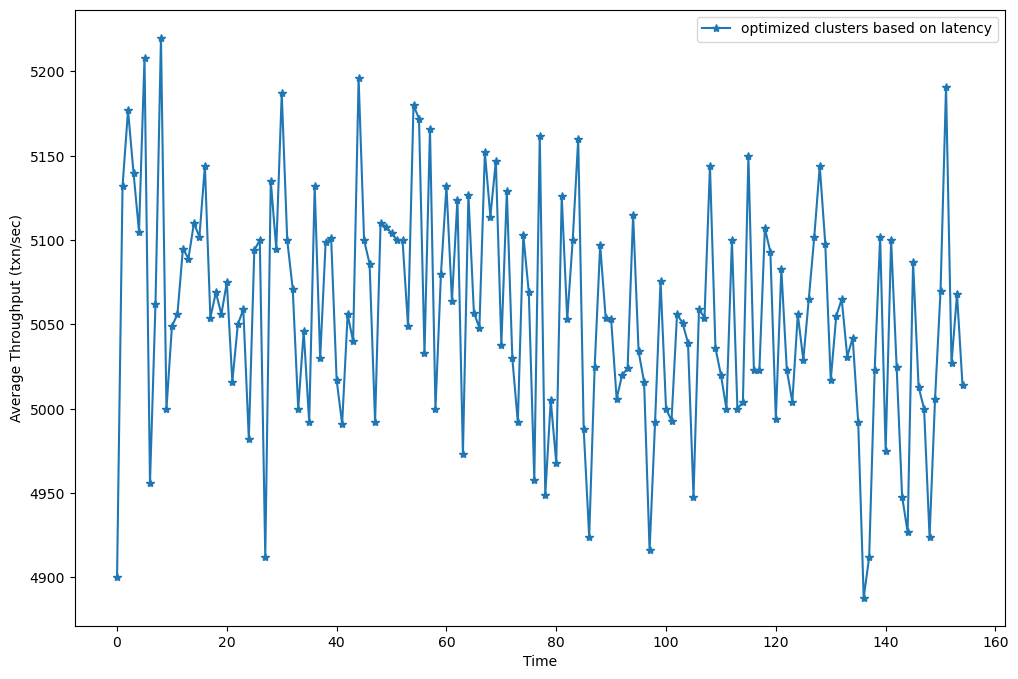

<Figure size 640x480 with 0 Axes>

In [65]:



fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')


pl.legend()
pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
# pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# pl.ylim(0,50)
# pl.savefig('/home/tejas/Desktop/OptClusters.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

In [66]:
# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# fig.patch.set_facecolor('white')
# pl.plot(s1,s2, '-*', label = 'Hotstuff-MC: Leader Failure')


# pl.legend()
# pl.xlabel('Time')
# pl.ylabel('Throughput (txn/sec)')
# # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# # pl.ylim(0,50)
# pl.savefig('/home/tejas/Desktop/LeaderFailure_HotStuffMC.png', dpi =150, bbox_inches = 0 )
# pl.show()
# pl.clf()

(0.8, 1.2)

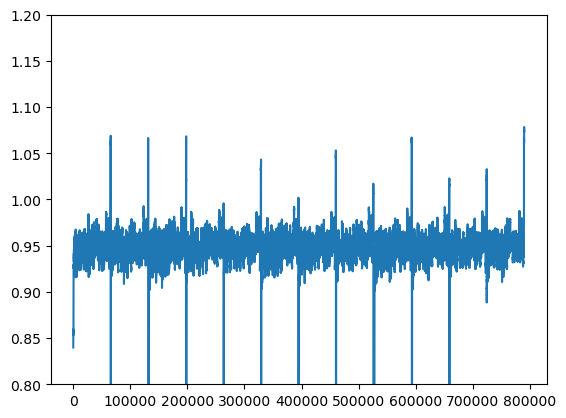

In [67]:
pl.plot(lats)
pl.ylim(0.8,1.2)

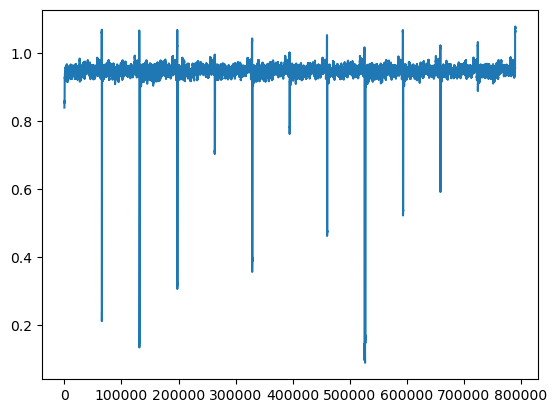

In [68]:
pl.plot(lats)
# pl.ylim(0,0.6)

In [69]:

os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')   


ERROR: (gcloud.compute.instances.delete) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/inst

Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-00].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-01].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-02].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-03].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-04].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-05].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-06].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-07].
Deleted [https://www.googleapis.com/comp

0

In [ ]:


# lats

# os.system('grep -n -r "LatencyPlot: new node sending join request message" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Received first message with new node info" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Leader received with tentative sets from all peer nodes" ../../../dump_files/')        

# 1000*(32.776365 - 32.768622)

# os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

# os.system('grep -n -r "LatencyPlot: Received initial join message" ../../../dump_files/')        

# os.system('grep -n -r "Sending Join Init message with height" ../../../dump_files/')        

# 1000*(17.534818-17.534437)

# os.system('grep -n -r "LatencyPlot: Sent response to  initial join message" ../../../dump_files/')        


    
# os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

# 17.536482

In [ ]:
# os.system('grep -n -r "quorum reached for second join message with cluster_id" ../../../dump_files/')

In [ ]:
# os.system('grep -n -r "LatencyPlot: Received 1st MC message" ../../../dump_files/')

In [ ]:
# os.system('grep -n -r "LatencyPlot: before sending first mc message" ../../../dump_files/')

In [ ]:
# 1000*(32.676090-32.612236)

In [ ]:
# os.system('grep -n -r "LatencyPlot: going to execute based on 2nd MC message" ../../../dump_files/')


# os.system('grep -n -r "LatencyPlot: Finished execution" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Processing message from client" ../../../dump_files/')    

In [ ]:
# os.system('grep -n -r "LatencyPlot: before initial join message" ../../../dump_files/')    

In [ ]:
# # os.system('grep -n -r "LatencyPlot: " ../../../dump_files/')

# 1000*(11.479877-11.479442), 1000*(11.484887-11.479877),1000*(56.048590-56.046569), 1000*(56.050021 - 56.048590)

# # exec, # first mc, #second mc

# 1000*(56.050377 - 56.050181), 1000*(56.049389-56.049025), 1000*(56.050875-56.049389), 1000*(56.046557-56.038591) 


# # with open('opt1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('opt1.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)
  
    








# # with open('equiCluster1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('equiCluster1.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)
  
    
    
    
# # with open('equiCluster.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)

    
# # with open('lat.npy', 'rb') as f:
# #     lat1 = np.load(f)
# #     lat2 = np.load(f)

    
    
# # with open('opt.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)


# fig = pl.figure(figsize = (12, 8))
# fig.patch.set_facecolor('white')
# pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')

# # pl.plot(eq1,eq2, '-*', label = 'optimized clusters: equal clusters (7 (R1),7 (R2)')
# # pl.plot(lat1,lat2, '-*', label = 'optimized clusters: latency (9 (R1),5 (R2))')
# # pl.plot(opt1,opt2, '-*', label = 'optimized clusters: latency and heterogeneity (4 (R1),5 (R1), 5 (R2))')
# pl.legend()
# pl.xlabel('Time')
# pl.ylabel('Average Throughput (txn/sec)')
# # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# # pl.ylim(0,350)
# # pl.savefig('/home/tejas/Desktop/OptClusters.png', dpi =150, bbox_inches = 0 )
# pl.show()
# pl.clf()

## Single Non-Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Single Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/NodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave

## Multiple Non Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==7:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==11:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.axvline(x=60, ls='--', color = 'green')
pl.axvline(x=80, ls='--', color = 'blue')

pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Multiple Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/MultiNodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave